# 5. Visualizations

## Top female rappers by total mentions

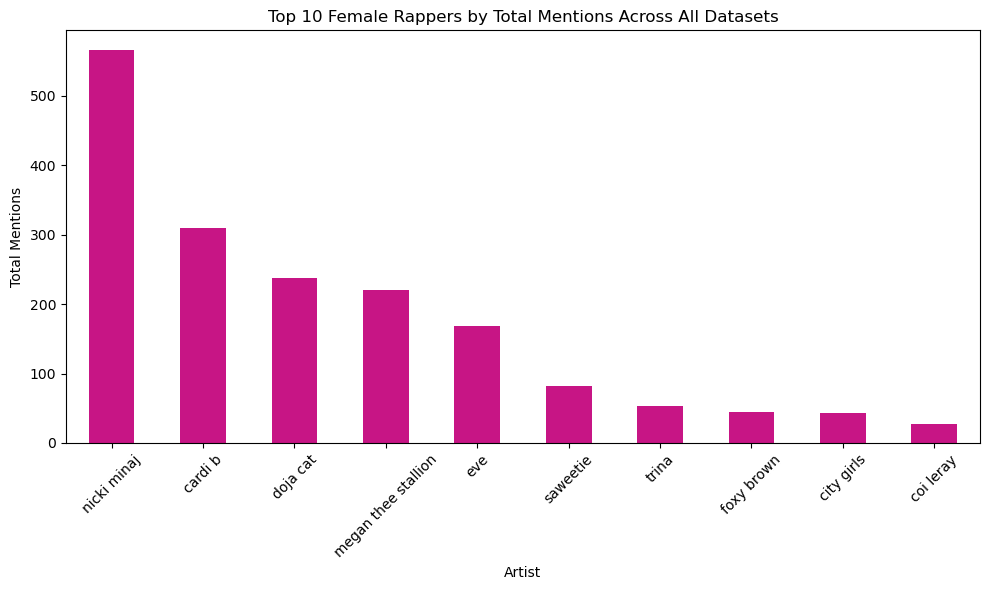

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and merge all datasets
df_billboard = pd.read_csv("billboard_hot_100_with_city.csv", sep=";", engine="python", on_bad_lines="skip")
df_spotify_hiphop = pd.read_csv("spotify_top_hiphop_artists_tracks_cities.csv", sep=";", engine="python", on_bad_lines="skip")
df_female = df_spotify_hiphop[df_spotify_hiphop['gender'].str.lower() == 'female']
df_spotify_10k = pd.read_csv("spotify_top_10k_streamed_songs.csv", sep=";", engine="python")
df_tidal = pd.read_csv("tidal_female_rappers_with_city.csv", sep=";", engine="python")
df_complex = pd.read_csv("complex_best_rap_cities.csv")

# Define non-rap artists 
non_rappers = [
    'beyonce', 'beyoncé', 'rihanna', 'dua lipa', 'sza',
    'ariana grande', 'adele', 'selena gomez', 'lizzo',
    'kesha', 'miley cyrus', 'lady gaga', 'taylor swift'
]

# Define cleaning and filtering function
def clean_and_filter(df):
    df['artist'] = df['artist'].astype(str).str.strip().str.lower()
    df['gender'] = df['gender'].astype(str).str.strip().str.lower()
    df = df[df['gender'] == 'female']
    df = df[~df['artist'].isin(non_rappers)]
    return df

# Filter each dataset
df_spotify_hiphop_f = clean_and_filter(df_spotify_hiphop)
df_spotify_10k_f = clean_and_filter(df_spotify_10k)
df_tidal_f = clean_and_filter(df_tidal)
df_billboard_f = clean_and_filter(df_billboard)

# Count mentions per artist per dataset
count_hiphop = df_spotify_hiphop_f['artist'].value_counts().rename('hiphop_count')
count_10k = df_spotify_10k_f['artist'].value_counts().rename('top10k_count')
count_tidal = df_tidal_f['artist'].value_counts().rename('tidal_count')
count_billboard = df_billboard_f['artist'].value_counts().rename('billboard_count')

# Merge all 
merged_df = pd.concat([count_hiphop, count_10k, count_tidal, count_billboard], axis=1).fillna(0)

# Add a total mentions column
merged_df['total_mentions'] = merged_df.sum(axis=1)

# Top 10 female rappers by total mentions 
df_top = merged_df.sort_values(by='total_mentions', ascending=False).head(10)

# Plot the result
plt.figure(figsize=(10, 6))
df_top['total_mentions'].plot(kind='bar', color='mediumvioletred')
plt.title('Top 10 Female Rappers by Total Mentions Across All Datasets')
plt.ylabel('Total Mentions')
plt.xlabel('Artist')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Top 10 cities by female rapper presence

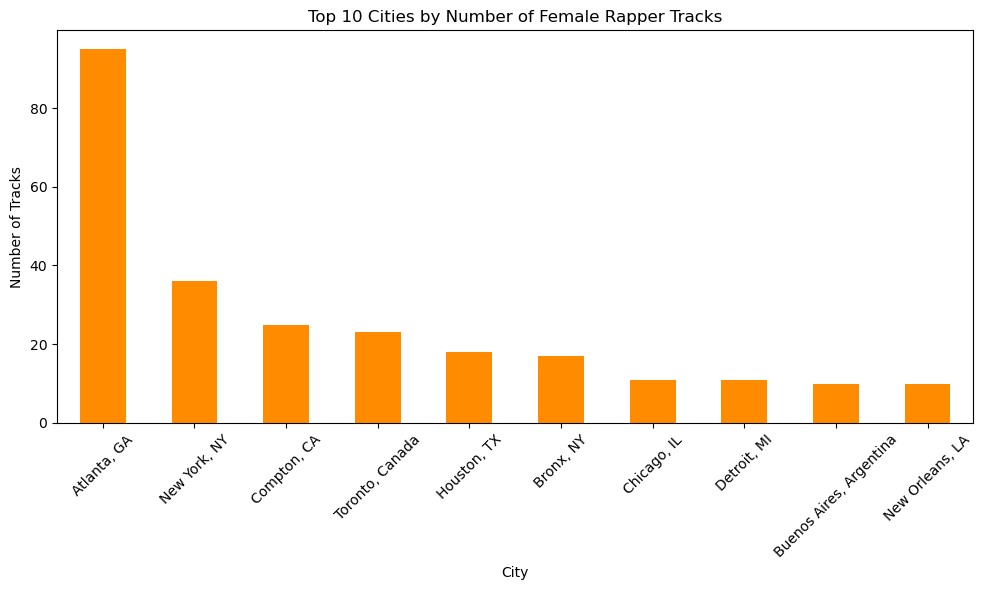

In [9]:
top_cities = df_spotify_hiphop['city'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_cities.plot(kind='bar', color='darkorange')
plt.title('Top 10 Cities by Number of Female Rapper Tracks')
plt.xlabel('City')
plt.ylabel('Number of Tracks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Hits by city across all datasets

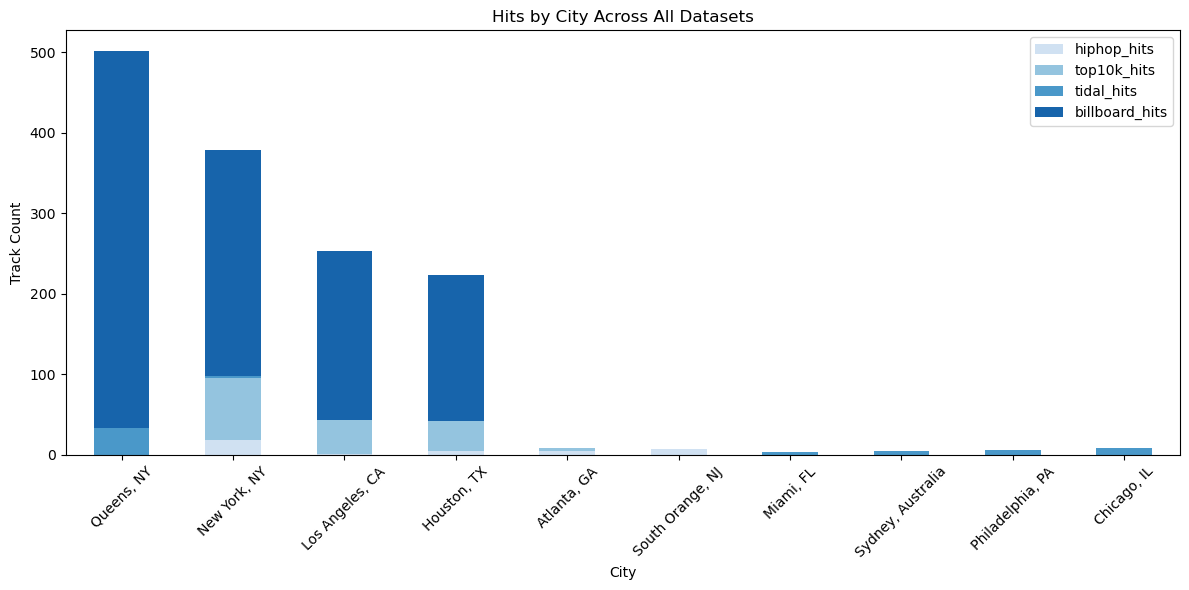

In [9]:
# Group by city and count per dataset
city_hiphop = df_spotify_hiphop_f['city'].value_counts().rename('hiphop_hits')
city_10k = df_spotify_10k_f['city'].value_counts().rename('top10k_hits')
city_tidal = df_tidal_f['city'].value_counts().rename('tidal_hits')
city_billboard = df_billboard_f['city'].value_counts().rename('billboard_hits')

# Merge all
city_hits = pd.concat([city_hiphop, city_10k, city_tidal, city_billboard], axis=1).fillna(0)

# Plot stacked bar
city_hits_top = city_hits.sort_values(by='billboard_hits', ascending=False).head(10)

blue_palette = sns.color_palette("Blues", 4)

city_hits_top.plot(kind='bar', stacked=True, figsize=(12, 6), color=blue_palette)
plt.title('Hits by City Across All Datasets')
plt.ylabel('Track Count')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Top 10 cities by total hits across all datasets

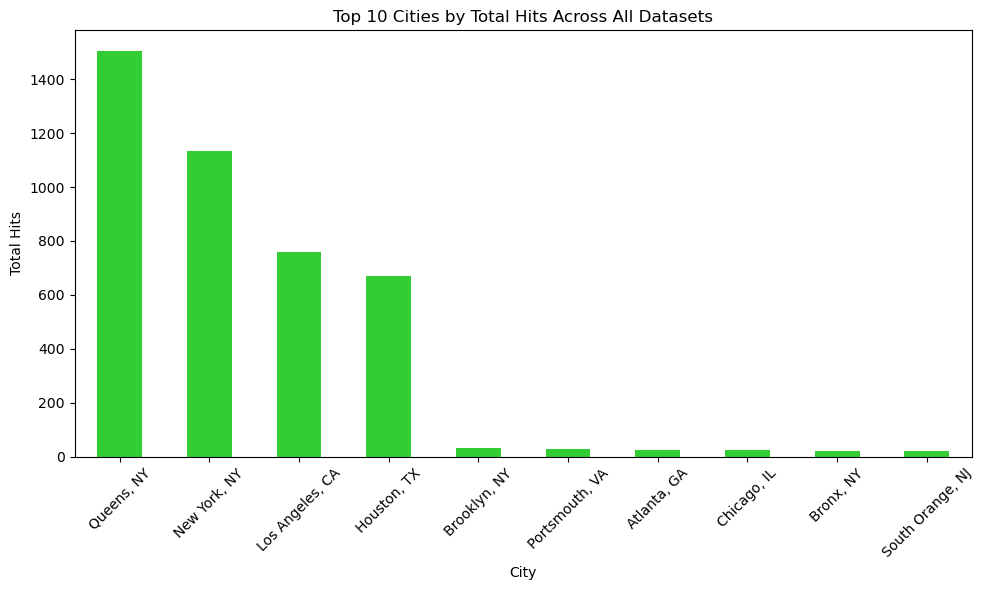

In [21]:
city_hits['total_hits'] = city_hits.sum(axis=1)
top_hit_cities = city_hits['total_hits'].sort_values(ascending=False).head(10)

top_hit_cities.plot(kind='bar', figsize=(10, 6), color='limegreen')
plt.title('Top 10 Cities by Total Hits Across All Datasets')
plt.xlabel('City')
plt.ylabel('Total Hits')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Confusion Matrix

In [15]:
print(merged_df.columns.tolist())

['hiphop_count', 'top10k_count', 'tidal_count', 'billboard_count', 'total_mentions']


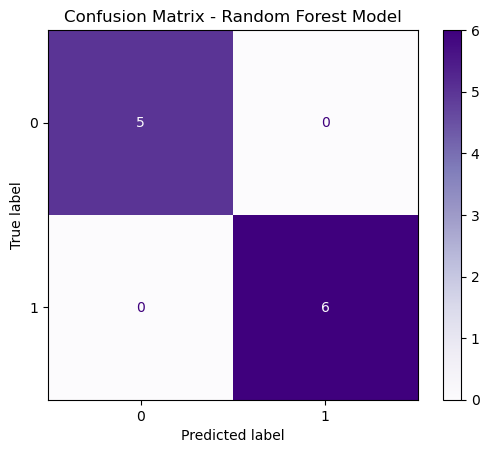

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# Define features 
X = merged_df[['hiphop_count', 'top10k_count', 'tidal_count', 'billboard_count']]

# Define target: 1 if popular, else 0
target = (merged_df['total_mentions'] >= 5).astype(int) 

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, target, test_size=0.3, random_state=42, stratify=target
)


# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Purples')
plt.title('Confusion Matrix - Random Forest Model')
plt.grid(False)
plt.show()

In [15]:
# Cross-validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, target, cv=5, scoring='accuracy')
print("CV accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

CV accuracy scores: [0.71428571 1.         0.85714286 1.         0.83333333]
Mean accuracy: 0.880952380952381


The Random Forest classifier predicted hits with high accuracy.

On the test set, the confusion matrix showed:
- 6 hits correctly predicted
- 5 non-hits correctly predicted
- 0 false positives / 0 false negatives

While this shows perfect prediction, the sample is small (n=11), which means performance should be interpreted with caution.

We then evaluated the model using 5-fold cross-validation to account for the limited dataset size. The average accuracy across folds was 88%, showing strong and stable performance. This means our model is able to predict whether a female rapper is likely to produce a hit.